In [25]:
#This is directly from the article  https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

import networkx as nx
import pandas as pd
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

In [206]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])
# pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
# nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

In [ ]:
#Import data 
data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated.head(10)

In [207]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, consolidated)

In [208]:
#Fit model to data
gcm.fit(scm, consolidated)

Fitting causal mechanism of node bandwidth: 100%|██████████| 17/17 [00:00<00:00, 106.69it/s]    


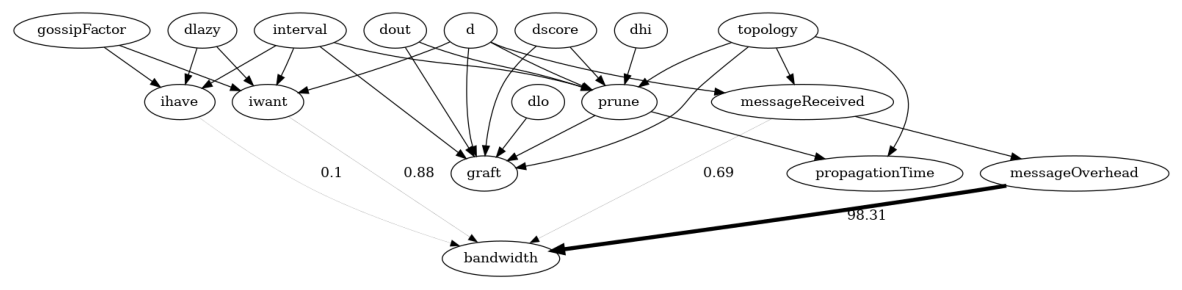

In [209]:
#Key factors influencing Bandwidth?

def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='bandwidth')


fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(causal_graph, causal_strengths=convert_to_percentage(arrow_strengths))#, figure_size=[15, 10])

Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): -5.307737915060364%: 100%|██████████| 1/1 [00:25<00:00, 25.37s/it]


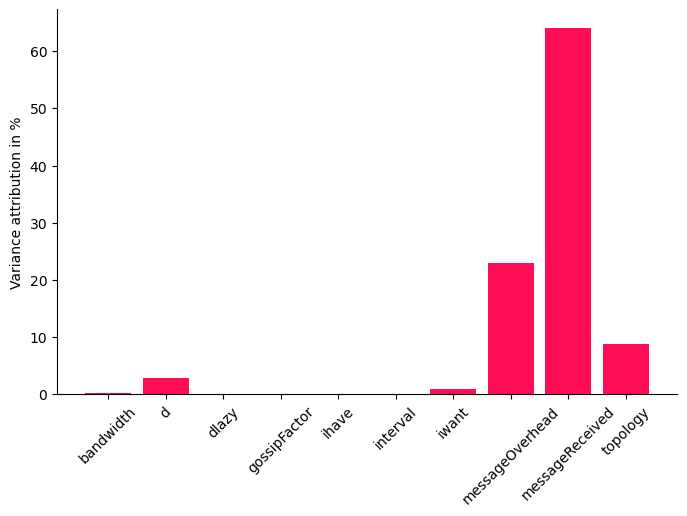

In [210]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()`


iccs = gcm.intrinsic_causal_influence(scm, target_node='bandwidth', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

<AxesSubplot:>

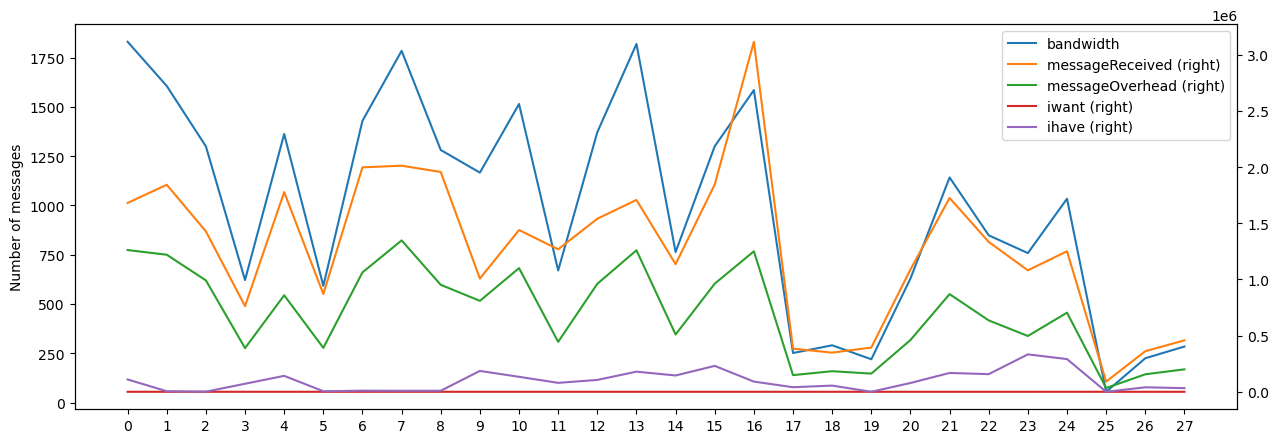

In [211]:
fig, ax = plt.subplots(figsize=(15,5)) 

ax = consolidated.plot(y='bandwidth', ylabel='Bandwidth in messages/s', rot=45, xticks=consolidated.index, ax=ax)
consolidated.plot(y='messageReceived', ax=ax, secondary_y = True, ylabel='Number of messages')

consolidated.plot(y = 'messageOverhead', ax=ax, secondary_y = True)
consolidated.plot(y = 'iwant', ax=ax, secondary_y = True)
consolidated.plot(y='ihave', ax=ax, secondary_y = True)
